In [2]:
import os
import numpy as np
from matplotlib import pyplot as plt

from mockfactory import Catalog, utils
from pypower import BaseMatrix, CatalogFFTPower, CatalogSmoothWindow, PowerSpectrumSmoothWindow, PowerSpectrumSmoothWindowMatrix, setup_logging

plt.style.use(os.path.join(os.path.abspath(''), 'plot_style.mplstyle'))
plots_dir = '../plots/'

### Generate spherical random catalog

In [41]:
size = int(1e6)
l = 1000
randoms = np.random.rand(3, size)*l

# radius of the spherical catalog
R = 500
center = np.array([500, 500, 500])
shifted_randoms = randoms - center[:, None]
spherical_mask = np.sum(shifted_randoms**2, axis=0) < R**2
spherical_randoms = randoms[:, spherical_mask]

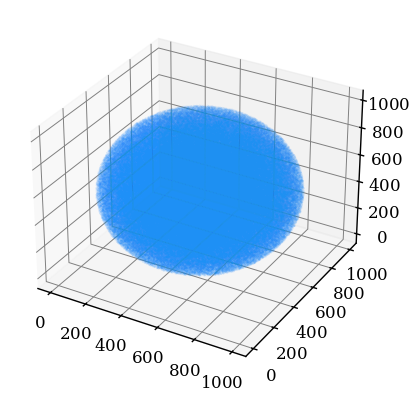

In [44]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(spherical_randoms[0], spherical_randoms[1], spherical_randoms[2], s=0.001)
plt.show()

### Power spectrum

In [108]:
power = CatalogFFTPower(data_positions1=spherical_randoms, randoms_positions1=spherical_randoms,
                            position_type='xyz', edges={'step': 0.005}, ells=(0),
                            boxpad=1.5, cellsize=6, resampler='tsc')

### Analytical window function

In [159]:
nbar = size / (4/3. * np.pi * R**3)

In [160]:
def shperical_window(s, R, nbar):
    res = 8 * np.pi**2 * nbar**2 * R**2 * (R + 3*s) / (6*s)
    return res

### Compute window function numerically

In [152]:
boxsizes = [1000, 2000, 5000]
windows = list()
windows_rpcut = list()

rpcut = 2.5

for boxsize in boxsizes:
    windows.append(CatalogSmoothWindow(randoms_positions1=spherical_randoms, power_ref=power, edges={'step': 1e-4}, projs=[(0, 0)], boxsize=boxsize, position_type='xyz'))
    windows_rpcut.append(CatalogSmoothWindow(randoms_positions1=spherical_randoms, power_ref=power, edges={'step': 1e-4}, projs=[(0, 0)], boxsize=boxsize, position_type='xyz', direct_edges = {'step': 0.1, 'max': 5000.}, direct_selection_attrs = {'rp': (0, rpcut)}))

In [153]:
window = PowerSpectrumSmoothWindow.concatenate_x(*[w.poles for w in windows], frac_nyq=0.9)
window_rpcut = PowerSpectrumSmoothWindow.concatenate_x(*[w.poles for w in windows_rpcut], frac_nyq=0.9)

In [154]:
sep = np.geomspace(1e-2, 5e4, 2048)
window_rpcut_approx = window.copy()
window_real = window.to_real(sep=sep)
window_rpcut_real = window_rpcut.to_real(sep=sep)
window_rpcut_approx_real = window_rpcut_approx.to_real(sep=sep).select(rp=(rpcut, np.inf))

/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20230725-1.0.0/conda/lib/python3.10/site-packages/numpy/lib/polynomial.py:1337: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


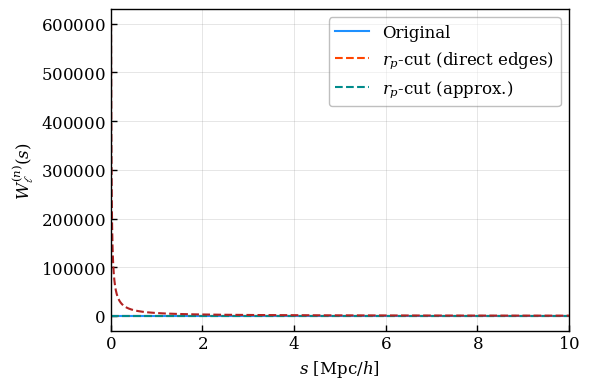

In [165]:
fig = plt.figure(figsize=(6, 4))
ax = plt.gca()

lines = []
for iproj, proj in enumerate([(0, 0)]):
    ax.plot(window_real.sep, window_real(proj=proj), label='Original')
    ax.plot(window_rpcut_real.sep, window_rpcut_real(proj=proj), ls='--', label=r'$r_{p}$-cut (direct edges)')
    ax.plot(window_rpcut_approx_real.sep, window_rpcut_approx_real(proj=proj), ls='--', label=r'$r_{p}$-cut (approx.)')
    ax.plot(window_real.sep, shperical_window(window_real.sep, R, nbar), ls='--')
    #ax.set_xscale('log')
    ax.set_xlim((0, 10))
ax.grid(True)
ax.set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
ax.set_ylabel(r'$W_{\ell}^{(n)}(s)$')
plt.legend()
plt.show()

### Window matrix

In [134]:
wm = PowerSpectrumSmoothWindowMatrix(power.poles.k, projsin=(0,), projsout=(0,), weightsout=power.poles.nmodes, window=window.to_real(sep=sep), kin_lim=(1e-4, 1.), sep=sep)
wm_rpcut = PowerSpectrumSmoothWindowMatrix(power.poles.k, projsin=(0,), projsout=(0,), weightsout=power.poles.nmodes, window=window_rpcut.to_real(sep=sep), kin_lim=(1e-4, 1.), sep=sep)

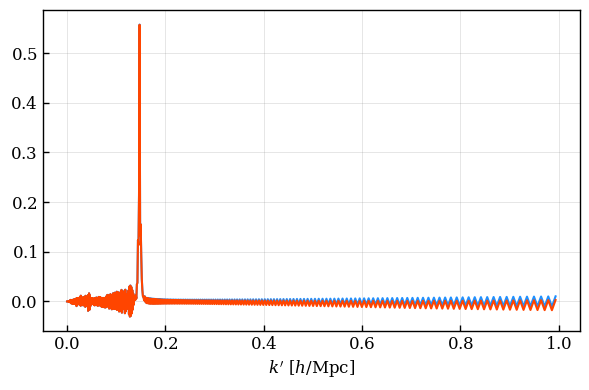

In [136]:
indexout = np.abs(wm.xout[0] - 0.15).argmin()
a = wm.unpacked()
a_rpcut = wm_rpcut.unpacked()

plt.plot(wm.xin[0], a[0][0][:, indexout])
plt.plot(wm_rpcut.xin[0], a_rpcut[0][0][:, indexout])
plt.xlabel(r'$k^\prime$ [$h/\mathrm{Mpc}$]')
plt.show()